In [1]:
from dataclasses import dataclass
from datetime import datetime, timedelta
import os
from pathlib import Path
from typing import List
pwd = Path(os.getcwd())

import pytz
import random
import sys
sys.path.append(str(pwd.parent))
sys.path.append(str(pwd.parent / "config"))

import warnings
warnings.simplefilter("ignore")

import networkx as nx
import numpy as np
from osmread import parse_file, Node, Way
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

from config import Config
from util import haversine
import matplotlib.pyplot as plt
import matplotlib as mpl

config = Config.load()

In [2]:
@dataclass
class Node:
    node_id: int
    node_index: int
    longitude: float
    latitude: float


class Grid:
    def __init__(
        self,
        idx,
        west_bound,
        east_bound,
        south_bound,
        north_bound,
        center_longitude,
        center_latitude,
    ):
        self.idx = idx
        self.__west_bound = west_bound
        self.__east_bound = east_bound
        self.__south_bound = south_bound
        self.__north_bound = north_bound
        self.__center_longitude = center_longitude
        self.__center_latitude = center_latitude
        self.__centroid = None
        self.__nodes = []
        self.__total_cost = 0.0
        self.done_flag = False

    @property
    def west_bound(self):
        return self.__west_bound

    @property
    def east_bound(self):
        return self.__east_bound

    @property
    def south_bound(self):
        return self.__south_bound

    @property
    def north_bound(self):
        return self.__north_bound

    @property
    def center_longitude(self):
        return self.__center_longitude

    @property
    def center_latitude(self):
        return self.__center_latitude

    @property
    def total_cost(self):
        return self.__total_cost
    
    def add_cost(self, cost: float) -> None:
        self.__total_cost += cost

    @property
    def centroid(self) -> Node:
        return self.__centroid

    def set_centroid(self, centroid: Node) -> None:
        self.__centroid = centroid
        self.__nodes.append(centroid)

    def get_nodes(self):
        return [node for node in self.__nodes]
        
    def add_node(self, node: Node) -> None:
        self.__nodes.append(node)

class GridManager:
    def __init__(self):
        self.__grid_list = []

    def add_grid(self, grid):
        self.__grid_list.append(grid)

    def get_grids(self):
        return [grid for grid in self.__grid_list]
        
    def get_minimun_cost_grid(self):
        min_cost = np.inf
        min_grid = None
        for grid in list(filter(lambda x: not x.done_flag, self.__grid_list)):
            if grid.total_cost < min_cost:
                min_grid = grid
            min_cost = min(min_cost, grid.total_cost)
        return min_grid

    def __len__(self):
        return len(self.__grid_list)
    

class CostDB:
    def __init__(self, cost_csv_path, node_csv_path) -> None:
        node_id_list_df = pd.read_csv(node_csv_path)
        self.node_id_map = {
            node_id: node_index for node_index, node_id in zip(
                node_id_list_df["NodeIndex"].values,
                node_id_list_df["NodeID"].values
            )
        }
        self.cost_matrix = pd.read_csv(cost_csv_path, header=None).values

    def calc_cost(self, start_node_id, end_node_id) -> float:
        start_idx = self.node_id_map[start_node_id]
        end_idx = self.node_id_map[end_node_id]
        return self.cost_matrix[start_idx][end_idx]
        

cost_db = CostDB(cost_csv_path="../data/AccurateMap.csv", node_csv_path="../data/Node.csv")

In [3]:
df = pd.read_csv("../data/NodeConnection.csv")
node_info_df = df[["NodeID", "Longitude", "Latitude"]].drop_duplicates()
node_info = {
    node_id: {
        "node_index": node_index,
        "longitude": longitude,
        "latitude": lattitude,
    } for node_index, (node_id, longitude, lattitude) in enumerate(
        zip(node_info_df["NodeID"].values, node_info_df["Longitude"].values, node_info_df["Latitude"].values))
}

In [4]:
__average_longitude = (config.LOCAL_REGION_BOUND.east_bound - config.LOCAL_REGION_BOUND.west_bound) / 2
__average_latitude = (config.LOCAL_REGION_BOUND.north_bound - config.LOCAL_REGION_BOUND.south_bound) / 2

num_grid_width = int(
    haversine(
        config.LOCAL_REGION_BOUND.west_bound,
        __average_latitude,
        config.LOCAL_REGION_BOUND.east_bound,
        __average_latitude,
    )
    / config.SIDE_LENGTH_KIRO_METER
    + 1
)
num_grid_height = int(
    haversine(
        __average_longitude,
        config.LOCAL_REGION_BOUND.south_bound,
        __average_longitude,
        config.LOCAL_REGION_BOUND.north_bound,
    )
    / config.SIDE_LENGTH_KIRO_METER
    + 1
)

In [5]:
total_width = config.LOCAL_REGION_BOUND.east_bound - config.LOCAL_REGION_BOUND.west_bound
total_height = config.LOCAL_REGION_BOUND.north_bound - config.LOCAL_REGION_BOUND.south_bound
interval_width = total_width / num_grid_width
interval_height = total_height / num_grid_height

In [6]:
# create grid
grid_manager = GridManager()
for i in range(num_grid_height):
    smaller_y = config.LOCAL_REGION_BOUND.south_bound + interval_height*i
    larger_y = config.LOCAL_REGION_BOUND.south_bound + interval_height*(i+1)
    for j in range(num_grid_width):    
        smaller_x = config.LOCAL_REGION_BOUND.west_bound + interval_width*j
        larger_x = config.LOCAL_REGION_BOUND.west_bound + interval_width*(j+1)

        grid_manager.add_grid(
            Grid(
                idx=i*num_grid_height + j,
                west_bound=smaller_x,
                east_bound=larger_x,
                south_bound=smaller_y,
                north_bound=larger_y,
                center_longitude=(smaller_x+larger_x)/2,
                center_latitude=(smaller_y+larger_y)/2,
            )
        )

center_lng_list = [grid.center_longitude for grid in grid_manager.get_grids()]
center_lat_list = [grid.center_latitude for grid in grid_manager.get_grids()]

# get nearest node
nn = NearestNeighbors(algorithm='ball_tree')
nn.fit(node_info_df[["Longitude", "Latitude"]].values)

node_id_list = node_info_df["NodeID"].values.tolist()

center_points_array = np.array([[center_lng, center_lat] for center_lng, center_lat in zip(center_lng_list, center_lat_list)])

_, nearest_node_idx= nn.kneighbors(center_points_array, n_neighbors=1)
nearest_node_id_list = [node_id_list[idx] for idx in nearest_node_idx.reshape(1,-1)[0]]
for node_id, grid in zip(nearest_node_id_list, grid_manager.get_grids()):
    node = Node(
        node_id=node_id,
        node_index=node_info[node_id]["node_index"],
        longitude=node_info[node_id]["longitude"],
        latitude=node_info[node_id]["latitude"],
    )
    grid.set_centroid(centroid=node)

In [7]:
graph = nx.Graph()
graph.add_nodes_from(df["NodeID"].drop_duplicates().values)
for from_node, to_node in zip(df["NodeID"].values, df["NextNodeID"].values):
    if to_node == -1:
        continue
    else:
        graph.add_edge(from_node, to_node)

In [8]:
# check
def draw(graph, df, grid_manager, node_info, config):
    MARGIN = 0.0005
    plt.figure(figsize=[15,15])

    def randomcolor() -> str:
        color_arr = list(mpl.colors.TABLEAU_COLORS.keys())
        return color_arr[random.randint(0, len(color_arr)-1)]

    node_id_to_grid_id = {}
    grid_id_to_color = {}
    for grid in grid_manager.get_grids():
        grid_id_to_color.update({grid.idx: randomcolor()})
        for node in grid.get_nodes():
            node_id_to_grid_id.update({node.node_id: grid.idx})

    for (start_point, end_point) in graph.edges():
        start_point_grid_id = node_id_to_grid_id[start_point]
        end_point_grid_id = node_id_to_grid_id[end_point]

        lngs = [node_info[start_point]["longitude"], node_info[end_point]["longitude"]]
        lats = [node_info[start_point]["latitude"], node_info[end_point]["latitude"]]
        plt.plot(lngs, lats, color=grid_id_to_color[start_point_grid_id])
        if start_point_grid_id != end_point_grid_id:
            plt.plot(lngs, lats, color=grid_id_to_color[end_point_grid_id])

    plt.title("New York Node Connection (2022-02-24)", fontsize=20)
    plt.xlabel("longitude", fontsize=15)
    plt.ylabel("latitude", fontsize=15)

    plt.scatter(
        center_lng_list,
        center_lat_list,
        marker="^",
        color="green",
        s=70,
        label="center of grid"
    )

    for i in range(num_grid_width+1):
        x = config.LOCAL_REGION_BOUND.west_bound + interval_width*i
        plt.plot([x, x], [config.LOCAL_REGION_BOUND.south_bound-MARGIN, config.LOCAL_REGION_BOUND.north_bound+MARGIN], linestyle='dotted', color="black")
    for i in range(num_grid_height+1):
        x = config.LOCAL_REGION_BOUND.south_bound + interval_height*i
        plt.plot([config.LOCAL_REGION_BOUND.west_bound-MARGIN, config.LOCAL_REGION_BOUND.east_bound+MARGIN], [x, x], linestyle='dotted', color="black")

    centroid_lng_list = [grid.centroid.longitude for grid in grid_manager.get_grids()]
    centroid_lat_list = [grid.centroid.latitude for grid in grid_manager.get_grids()]
    plt.scatter(centroid_lng_list, centroid_lat_list, marker=",", color="orange", s=70, label="centroid")
    plt.legend()
    plt.show()

In [9]:
all_nodes = df["NodeID"].drop_duplicates().values.tolist()
processed_node_id_set = set()
for grid in grid_manager.get_grids():
    all_nodes.remove(grid.centroid.node_id)
    processed_node_id_set.add(grid.centroid.node_id)

while len(all_nodes)>0:
    min_cost_grid = grid_manager.get_minimun_cost_grid()
    adj_node_id_set = set()
    grid_nodes_set = set([node.node_id for node in min_cost_grid.get_nodes()])
    for node_id in grid_nodes_set:
        adj_node_id_set = adj_node_id_set.union(set([k for k in graph.adj[node_id].keys()]))
    candidate_nodes_set = adj_node_id_set.difference(grid_nodes_set)
    candidate_nodes_set = candidate_nodes_set.difference(processed_node_id_set)  # select candidate nodes for add this grid.
    if len(candidate_nodes_set) == 0:
        min_cost_grid.done_flag = True
        continue
    minimum_vertex_cost = np.inf
    tmp_min_cost_node_id = None
    tmp_nearest_node_id = None

    tmp_adj_candidate_nodes_set = set()
    for node_id in candidate_nodes_set:
        tmp_adj_candidate_nodes_set = tmp_adj_candidate_nodes_set.union(set([k for k in graph.adj[node_id].keys()]))
    adj_candidate_nodes_set = tmp_adj_candidate_nodes_set.intersection(grid_nodes_set)  # select nodes that is contained by this grid and is candidate.
    for candidate_node_id in candidate_nodes_set:
        for adj_node_id in adj_candidate_nodes_set:
            tmp_cost = cost_db.calc_cost(candidate_node_id, adj_node_id) + cost_db.calc_cost(candidate_node_id, min_cost_grid.centroid.node_id)
            if tmp_cost < minimum_vertex_cost:
                minimum_vertex_cost = tmp_cost
                tmp_min_cost_node_id = candidate_node_id
                tmp_nearest_node_id = adj_node_id
    adj_node = Node(
        node_id=tmp_min_cost_node_id,
        node_index=node_info[tmp_min_cost_node_id]["node_index"],
        longitude=node_info[tmp_min_cost_node_id]["longitude"],
        latitude=node_info[tmp_min_cost_node_id]["latitude"]
    )
    min_cost_grid.add_node(adj_node)
    min_cost_grid.add_cost(cost_db.calc_cost(tmp_nearest_node_id, adj_node.node_id))
    all_nodes.remove(adj_node.node_id)
    processed_node_id_set.add(adj_node.node_id)

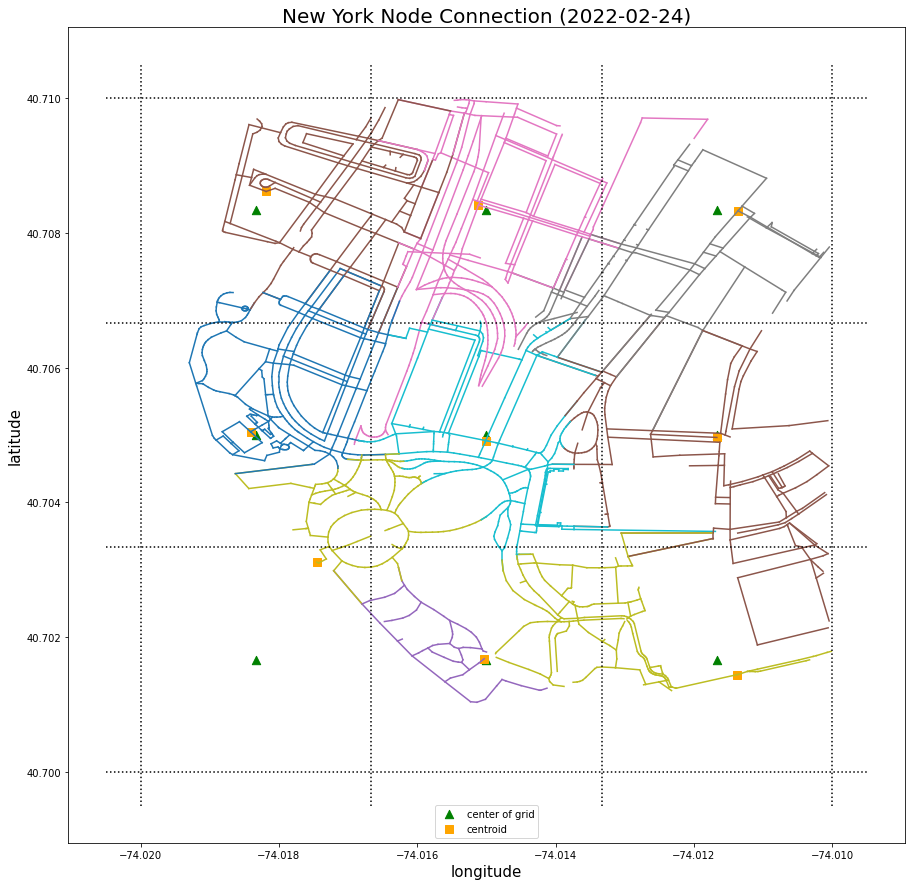

In [10]:
draw(graph, df, grid_manager, node_info, config)

In [12]:
node_id_to_grid_id = {}
grid_id_to_color = {}
for grid in grid_manager.get_grids():
    for node in grid.get_nodes():
        node_id_to_grid_id.update({node.node_id: grid.idx})
node_id_list_df = pd.read_csv("../data/Node.csv")
node_id_list_df["GridID"] = node_id_list_df["NodeID"].map(node_id_to_grid_id)
node_id_list_df[["NodeIndex", "NodeID", "GridID"]].to_csv(f"../data/({config.LOCAL_REGION_BOUND}){len(grid_manager)}TransportationClusteringCluster.csv", index=False)